In [1]:
from itertools import count

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
FIGSIZE = 10, 10
MAP_X = (45, 55)
MAP_Y = (45, 55)

# Proportions of each age/sex group 
# The numbers here are based on a large date set from Northern IL, where 
# the age classes are: young--fawns (age < 1 yr), adolescents--yearlings 
# (1 ≤ age < 2 yr), and adults (age ≥ 2)
M_YOUNG = 0.212
M_ADOLESCENT = 0.088
M_ADULT = 0.087
F_YOUNG = 0.186 
F_ADOLESCENT = 0.084
F_ADULT = 0.343
assert (M_YOUNG + M_ADOLESCENT + M_ADULT + F_YOUNG + F_ADOLESCENT 
        + F_ADULT) == 1, 'Population proportions do not sum to 1'

# Disease
# Inital proportion of population with the disease (on [0, 1]).
INIT_PREVALENCE = 0.01

# Population densities
# Whole area (in numbers per square unit in MAP_X, MAP_Y units)
DENSITY =  4.5
# For the example, this number is for Illinois Population Densities 
# (ROSEBERRY & WOOLFE (1998)) in deer/sq.km
MAX_DENSITY = 9
# For Illinois deer, Roseberry & Woolfe 1998 estimated around 16 in ideal 
# habitat; 9 is a compromise between current est of 4.5 and max of 16

# Dispersion and Migration
# Illinois Mean Dispersal Distances in km (From Nixon)
# Mean dispersal distance by sex
DISPERSAL_DIST = {'male': 40.9, 'female': 49.0}

# Probability of dispersal by sex and age class (assuming not already 
# dispersed)
DISPERSAL_PROB = {
    'male':   {'young': 0.51, 'adolescent': 0.21, 'adult': 0},
    'female': {'young': 0.50, 'adolescent': 0.21, 'adult': 0}}

# Proportion of animals migrating by age class
F_ADOLESCENT_MIGRATE_PROP = 0.196
F_ADULT_MIGRATE_PROP = 0.196
# Mean and standard deviation for distance migrated
F_ADOLESCENT_MIGRATE_MEAN = 20.8
F_ADOLESCENT_MIGRATE_SD = 7.9
F_ADULT_MIGRATE_MEAN = 7.3
F_ADULT_MIGRATE_SD = 5.2

In [3]:
# Simulation Values
ITERATIONS = 10

# Colors
# Define colors to be used to plot each sex and age-class
COLORS = {'male':   {'neo':        '#00FF00', 
                     'young':      '#00FFFF',
                     'adolescent': '#5050FF', 
                     'adult':      '#000077'},
          'female': {'neo':        '#FFFF00', 
                     'young':      '#FFB3B3',
                     'adolescent': '#FF0066', 
                     'adult':      '#AA0000'}}
PLOT_SIZE = {'neo': 16,
             'young': 32,
             'adolescent': 64,
             'adult': 128}

In [4]:
class Animal:
    _ID = count(0)
    
    def __init__(self, age, sex, winter_coords=None):
        self.ID = next(self._ID)
        self.age = age
        self.sex = sex
        self.winter_coords = winter_coords or self._get_random_coords()
        self.summer_coords = [np.nan, np.nan]
        self.disease_status = 'negative'
        self.years_infected = np.nan
        self.dispersed = False
        self.dispersed_this_year = False
        self.vital = 'alive'
        self.mother_id = np.nan
        
    def _get_random_coords(self):
        return [np.random.uniform(MAP_X[0], MAP_X[1]), 
                np.random.uniform(MAP_X[0], MAP_X[1])]
    
    def disperse(self):
        if self.dispersed:
            return
        prob = DISPERSAL_PROB[self.sex][self.age]
        ready = np.random.choice([True, False], p=[prob, 1 - prob])
        if ready:
            mean_dist = DISPERSAL_DIST[self.sex]
            dist = np.random.chisquare(df=mean_dist)
            theta = np.random.uniform(0, 2*np.pi)
            dx = dist * np.cos(theta)
            dy = dist * np.sin(theta)
            self.winter_coords[0] += dx
            self.winter_coords[1] += dy
            self.dispersed = True
            self.dispersed_this_year = True

    def __str__(self):
        disease_str = self.disease_status
        if disease_str == 'positive':
            disease_str += '(%d yrs)' % (self.years_infected)
        return ('Animal %d: %s %s\n Winters at (%.4f, %.4f)\n' 
                ' Summers at (%.4f, %.4f)\n Disease %s'
                % (self.ID, self.age, self.sex, self.winter_coords[0], 
                   self.winter_coords[1], self.summer_coords[0], 
                   self.summer_coords[1], disease_str))

    def to_dataframe(self):
        return pd.DataFrame(
            {'id': self.ID,
             'age': self.age,
             'sex': self.sex,
             'mother_id': self.mother_id,
             'x_winter': self.winter_coords[0],
             'y_winter': self.winter_coords[1],
             'x_summer': self.summer_coords[0],
             'y_summer': self.summer_coords[1],
             'disease_status': self.disease_status,
             'years_infected': self.years_infected,
             'dispersed': self.dispersed,
             'dispersed_this_year': self.dispersed_this_year,
             'vital': self.vital},
            index=[self.ID])

In [5]:
class Population:
    def __init__(self):
        self.n_animal = int(np.round(
            (MAP_X[1] - MAP_X[0]) * (MAP_Y[1] - MAP_Y[0]) * DENSITY))
        self.demographics = self._get_initial_demographics()
        self.n_positive = (
            int(np.round(INIT_PREVALENCE) * self.n_animal) or 1)
        #self.n_female = sum(demographics[x] for x in demographics 
        #                    if x.startswith('f'))
        #self.n_male = sum(demographics[x] for x in demographics 
        #                  if x.startswith('m'))
        self.population = self._initialize_population()
        
    def _get_initial_demographics(self):
        categories = ['male_young', 'male_adolescent', 'male_adult', 
                      'female_young', 'female_adolescent', 'female_adult']
        sex_age = [
            M_YOUNG, M_ADOLESCENT, M_ADULT, F_YOUNG, F_ADOLESCENT, F_ADULT]
        numbers = {}
        for pop, prop in zip(categories, sex_age):
            numbers[pop] = int(np.round(prop * self.n_animal))
        return numbers
    
    def _initialize_population(self):
        print('Initializing population...')
        population = []
        young_inds = []
        mother_candidates = []
        i = 0
        for age_sex, n in self.demographics.items():
            if age_sex == 'n_positive': pass
            sex, age = age_sex.split('_')
            for _ in range(n):
                if age == 'young':
                    young_inds.append(i)
                elif sex == 'female':
                    mother_candidates.append(i)
                animal = Animal(age, sex)
                population.append(animal)
                i += 1
        population = self._assign_mothers(
            population, young_inds, mother_candidates)
        population = self._initialize_disease(population)
        return population
    
    def _assign_mothers(self, population, young_inds, mother_candidates):
        for i in young_inds:
            mother_id = np.random.choice(mother_candidates)
            winter_coords = population[mother_id].winter_coords
            population[i].mother_id = mother_id
            population[i].winter_coords = winter_coords
        return population
    
    def _initialize_disease(self, population):
        disease_inds = np.random.choice(range(len(population)), 
                                        self.n_positive)
        for i in disease_inds:
            population[i].disease_status = 'positive'
            population[i].years_infected = 0
        return population
    
    def disperse(self):
        for animal in self.population:
            animal.disperse()
            
    def to_dataframe(self):
        df = self.population[0].to_dataframe()
        for animal in self.population[1:]:
            df = df.append(animal.to_dataframe())
        return df
    
    def plot(self):
        df = self.to_dataframe()
        plt.figure(figsize=FIGSIZE)
        for sex in ['female', 'male']:
            for age in ['adult', 'adolescent', 'young']:
                plt.scatter(
                    df.loc[((df.sex == sex) & (df.age == age)), 
                           'x_winter'], 
                    df.loc[((df.sex == sex) & (df.age == age)), 
                           'y_winter'],
                    color=COLORS[sex][age],
                    s=PLOT_SIZE[age],
                    alpha=0.8,
                    label='%s %s' % (age, sex))
        plt.scatter(df.loc[df.disease_status == 'positive', 'x_winter'],
                    df.loc[df.disease_status == 'positive', 'y_winter'],
                    marker='+',
                    color='k',
                    s=128,
                    label='disease positive')
        plt.legend();    

Initializing population...


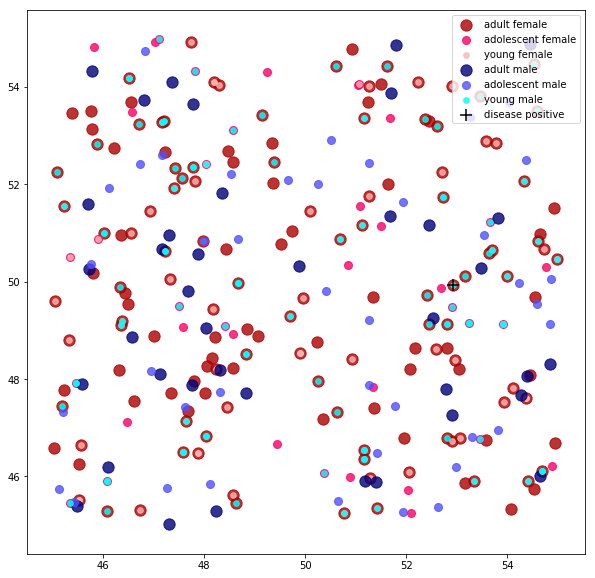

In [6]:
population = Population()
population.plot()

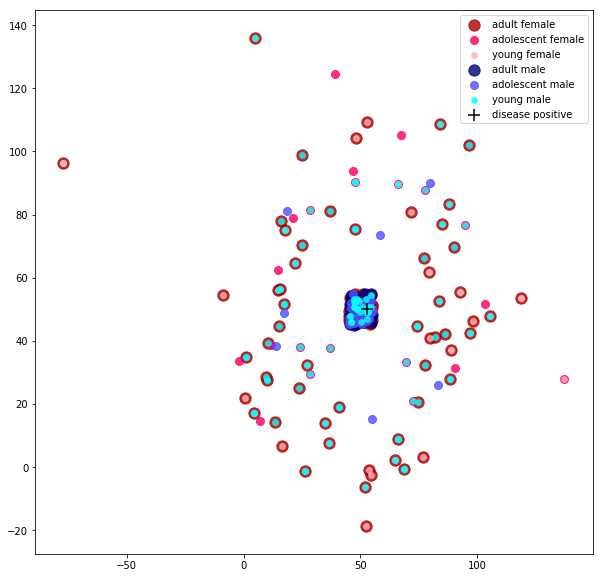

In [7]:
population.disperse()
population.plot()